In [1]:
from nipype import Node, Workflow, Merge, IdentityInterface, SelectFiles, MapNode
from nipype.interfaces.io import DataSink
import nibabel as nb
import matplotlib.pyplot as plt
from nipype.interfaces.fsl import ExtractROI, MCFLIRT, FLIRT, Threshold, ApplyMask
from nipype.interfaces.spm import SliceTiming, NewSegment
from nilearn import image as nli
from nilearn.plotting import plot_stat_map, plot_anat, plot_epi
from nipype.algorithms.rapidart import ArtifactDetect
from nipype.algorithms.confounds import TSNR
from nipype.workflows.fmri.fsl.preprocess import create_susan_smooth
from IPython.display import Image, SVG
import numpy as np
from nipype.algorithms.misc import Gunzip

/opt/miniconda-latest/envs/neuro/lib/python3.8/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 2] No such file or directory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
/opt/miniconda-latest/envs/neuro/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/opt/miniconda-latest/envs/neuro/lib/python3.8/site-packages/niflow/nipype1/workflows/dmri/mrtrix/group_connectivity.py:16: UserWarning: cmp not installed
  warnings.warn('cmp not installed')
/src/nipype/nipype/workflows/__init__.py:28: UserWarning: Nipype 1 workflows have been moved to the niflow-nipype1-workflows package. nipype.workflows.* provides a reference for backwards compatibility. Please use niflow.nipy

In [2]:
gunzip_func = Node(Gunzip(),  name='gunzip_func')

In [3]:
subject_list = ['%02d'%i for i in range(1,2)]
# String template with {}-based strings
templates = {'anat': 'sub-{subject_id}/ses-test/anat/sub-{subject_id}_ses-test_anat_sT1W.nii',
             'func': 'sub-{subject_id}/ses-test/func/sub-{subject_id}_ses-test_session_bold_merged.nii.gz'}
# Create SelectFiles node
selectfiles = Node(SelectFiles(templates,
                      base_directory='/home/neuro/Data/Visual_search_task/BIDS_data',
                      sort_filelist=True), name='selectfiles')
selectfiles.iterables = [('subject_id', subject_list)]

In [4]:
slice_order = list(range(1, 32, 2)) + list(range(2, 32, 2))
slicetime = Node(SliceTiming(num_slices=31,
                             ref_slice=2,
                             slice_order=slice_order,
                             time_repetition=2,
                             time_acquisition=2-(2/31)), name='slicetime')

stty: 'standard input': Inappropriate ioctl for device


In [5]:
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True), name="mcflirt")

In [6]:
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'), name="art")

In [7]:
# Use the following tissue specification to get a GM and WM probability map
tpm_img ='/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii'
tissue1 = ((tpm_img, 1), 1, (True,False), (False, False))
tissue2 = ((tpm_img, 2), 1, (True,False), (False, False))
tissue3 = ((tpm_img, 3), 2, (True,False), (False, False))
tissue4 = ((tpm_img, 4), 3, (False,False), (False, False))
tissue5 = ((tpm_img, 5), 4, (False,False), (False, False))
tissue6 = ((tpm_img, 6), 2, (False,False), (False, False))
tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]
segment = Node(NewSegment(tissues=tissues), name='segment')

In [8]:
coreg = Node(FLIRT(dof=6,
                   cost='bbr',
                   schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch',
                   output_type='NIFTI'), name="coreg")

In [9]:
# Threshold - Threshold WM probability image
threshold_WM = Node(Threshold(thresh=0.5,
                              args='-bin',
                              output_type='NIFTI'), name="threshold_WM")
# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[1][0]

In [10]:
# Specify the isometric voxel resolution you want after coregistration
desired_voxel_iso = 4
# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=desired_voxel_iso,
                       output_type='NIFTI'), name="applywarp")

In [11]:
susan = create_susan_smooth(name='susan')
susan.inputs.inputnode.fwhm = 8

In [12]:
# Initiate resample node
resample = Node(FLIRT(apply_isoxfm=desired_voxel_iso,
                      output_type='NIFTI'), name="resample")

In [13]:
# Threshold - Threshold GM probability image
mask_GM = Node(Threshold(thresh=0.5,
                         args='-bin -dilF',
                         output_type='NIFTI'), name="mask_GM")

# Select GM segmentation file from segmentation output
def get_gm(files):
    return files[0][0]

In [14]:
mask_func = MapNode(ApplyMask(output_type='NIFTI'),
                    name="mask_func", 
                    iterfield=["in_file"])

In [15]:
detrend = Node(TSNR(regress_poly=2), name="detrend")

In [16]:
datasink = Node(DataSink(base_directory='/home/neuro/Result/Visual_search_task/preproc_merged/',
                         container='preproc_result'), name="datasink")

In [17]:
substitutions = [('asub', 'sub'),
                 ('.nii.gz.par', '.par')]

# To get rid of the folder '_subject_id_07' and renaming detrend
substitutions += [('_subject_id_%s/detrend' % s,
                   '_subject_id_%s/sub-%s_detrend' % (s, s)) for s in subject_list]
substitutions += [('_subject_id_%s/' % s, '') for s in subject_list]
datasink.inputs.substitutions = substitutions

In [27]:
preproc = Workflow(base_dir='/home/neuro/Result/Visual_search_task/preproc_merged', name='preproc')

In [28]:
preproc.connect([ (selectfiles, gunzip_func, [('func', 'in_file')]),
                  (gunzip_func, slicetime, [('out_file', 'in_files')]),
                  (slicetime, mcflirt, [('timecorrected_files', 'in_file')]),
                  (mcflirt, art, [('out_file', 'realigned_files'), ('par_file', 'realignment_parameters')]), 
                  (selectfiles, segment, [('anat', 'channel_files')]), 
                  (selectfiles, coreg, [('anat', 'reference')]), 
                  (mcflirt, coreg, [('mean_img', 'in_file')]), 
                  (segment, threshold_WM, [(('native_class_images', get_wm), 'in_file')]), 
                  (threshold_WM, coreg, [('out_file', 'wm_seg')]), 
                  (mcflirt, applywarp, [('out_file', 'in_file')]),
                  (coreg, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                  (selectfiles, applywarp, [('anat', 'reference')]), 
                  (applywarp, susan, [('out_file', 'inputnode.in_files')]), 
                  (segment, resample, [(('native_class_images', get_gm), 'in_file'), 
                                        (('native_class_images', get_gm), 'reference')]), 
                  (resample, mask_GM, [('out_file', 'in_file')]), 
                  (mask_GM, susan, [('out_file', 'inputnode.mask_file')]), 
                  (susan, mask_func, [('outputnode.smoothed_files', 'in_file')]),
                  (mask_GM, mask_func, [('out_file', 'mask_file')]), 
                  (mask_func, detrend, [('out_file', 'in_file')])])
preproc.connect([(art, datasink, [('outlier_files', 'outlier_files'),
                                  ('plot_files', 'plot_files')]),
                 (mcflirt, datasink, [('par_file', 'par')]),
                 (detrend, datasink, [('detrended_file', 'func')]),
                 ])

211201-12:45:31,180 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Visual_search_task/preproc_merged/preproc/graph.png (graph2use=flat, simple_form=True).


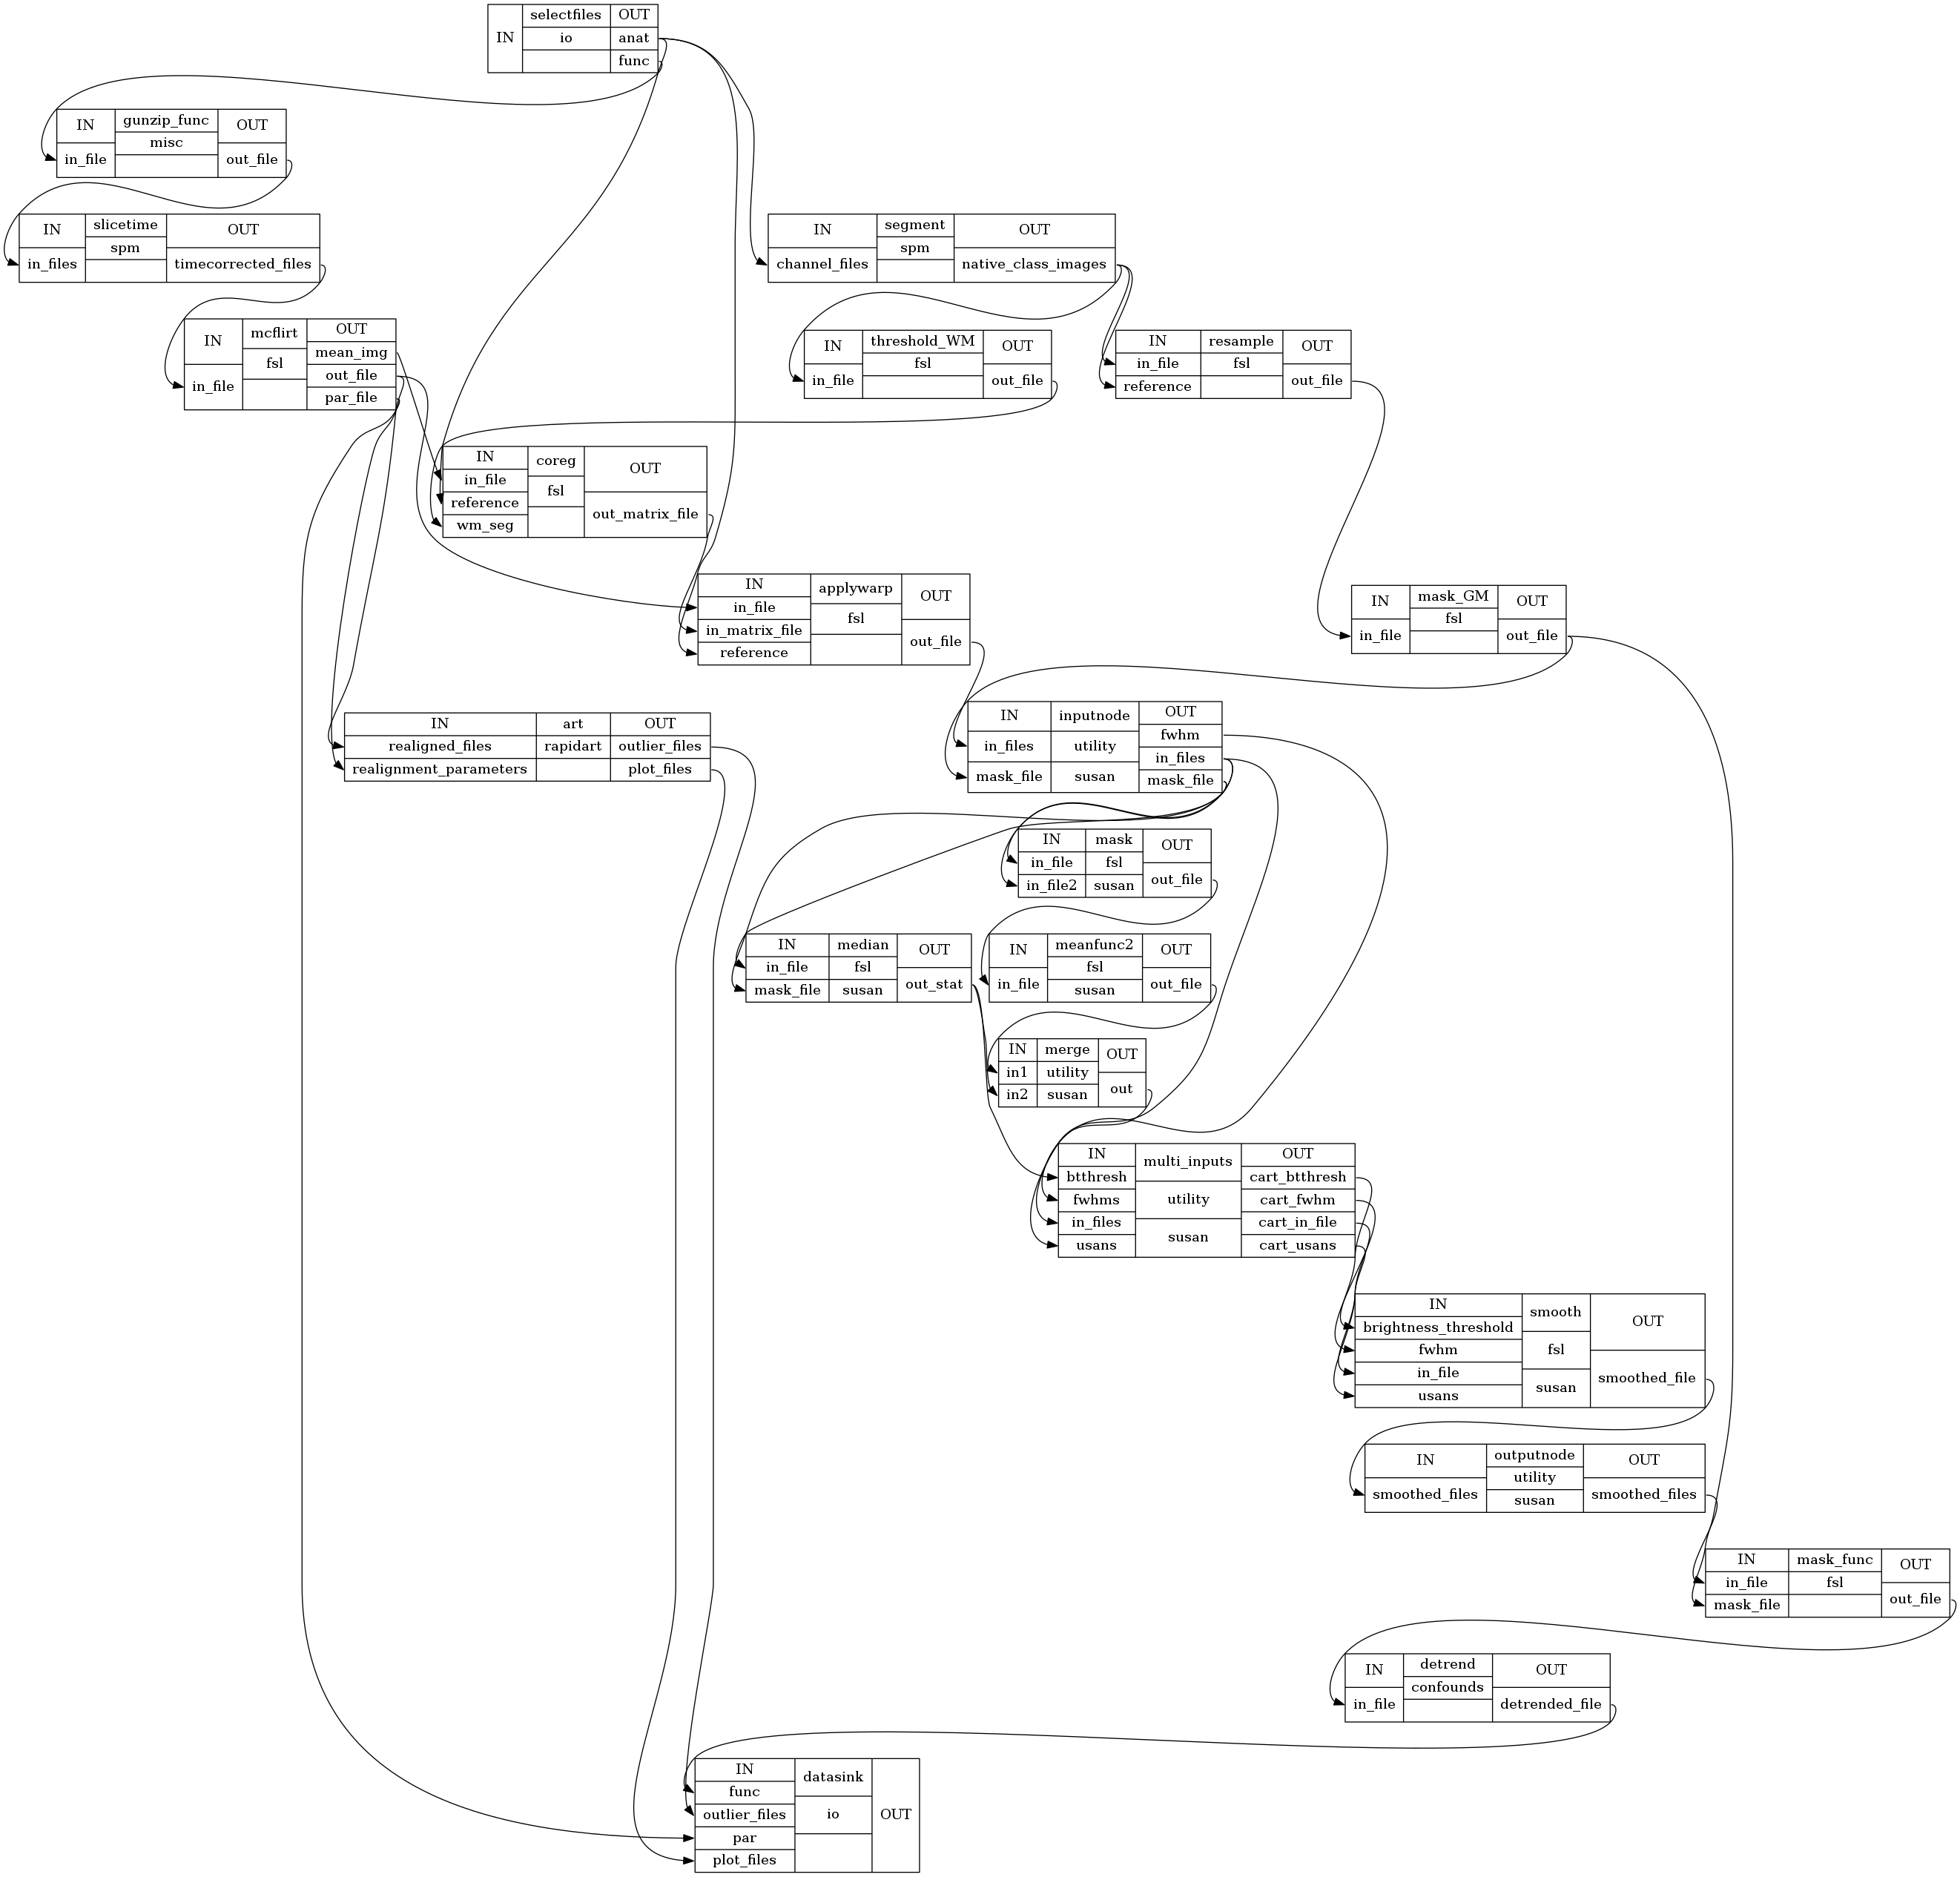

In [25]:
preproc.write_graph(graph2use='flat')
Image('/home/neuro/Result/Visual_search_task/preproc_merged/preproc/graph_detailed.png')

211201-12:46:31,706 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Visual_search_task/preproc_merged/preproc/graph.png (graph2use=colored, simple_form=True).


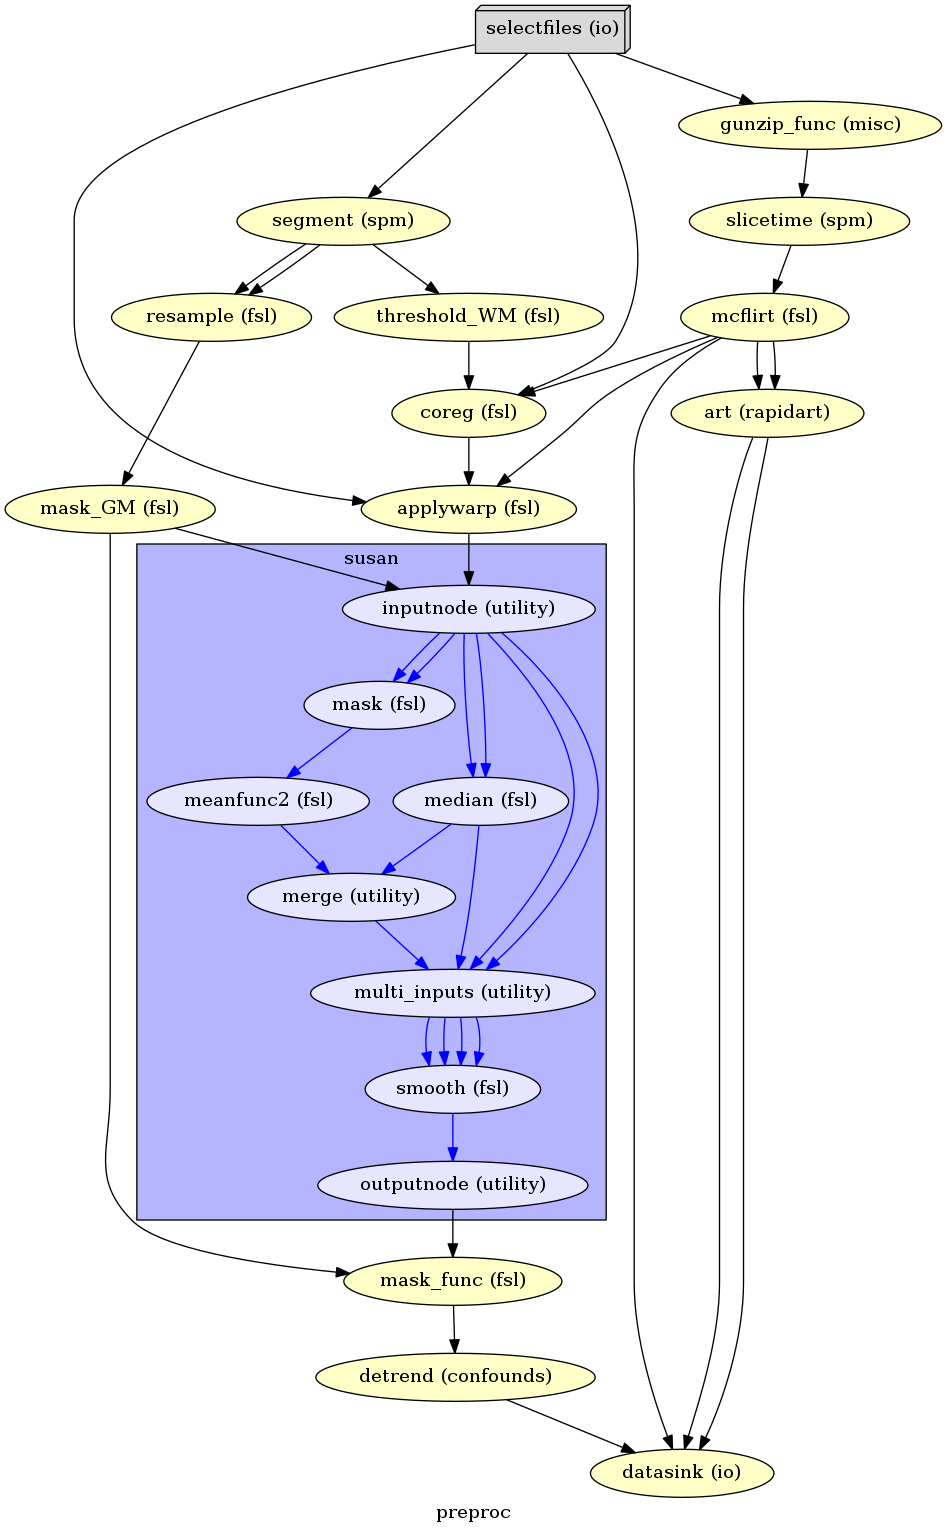

In [29]:
preproc.write_graph(graph2use='colored', format='png', simple_form=True)
Image(filename='/home/neuro/Result/Visual_search_task/preproc_merged/preproc/graph.png', width=750)

In [30]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

FileNotFoundError: [Errno 2] No such file or directory